# Persistent Homology of Stack Overflow Tags
This project computes the persistent homology on a subset of the most popular [Stack Overflow](https://stackoverflow.com/) tags.
The idea is that this type of analysis may reveal distinct "clusters" of tags which are often used on the same post
(i.e., one might expect "javascript" and "json" to be tagged on the same posts more frequently than "javascript" and "python").

## Data Cleaning
Ideally, we could compute the persistent homology of tags over $\textit{all}$ posts on Stack Overflow, but the data set of all such posts is far too large for most machines to handle.
Instead, it is computationally easier to work with a random sample of $50,000$ posts obtained via the [Data Explorer](https://data.stackexchange.com/).
Additionally, it also makes sense to consider only the "sufficiently popular" tags. We have no need to consider the clustering of tags used, say, $3$ times across the entire website.
The program starts with the $21,480$ most popular tags (all other tags have less than $100$ uses across all of Stack Exchange) then counts only those with $\textit{at least}$ $100$ uses across the $50,000$ posts.
This substantially reduces the number of tags we're working with to make the remaining work less time consuming.

In [1]:
from csv import writer
import re #needed to handle special characters when searching for tags (i.e., c++)
import matplotlib as plt #needed for visualization
import pandas as pd
import gudhi

Now that we have our imports, we can read in the sample of posts and the tags. Of particular interest is the tag

In [2]:
all_Posts = pd.read_csv('PostSample.csv')
all_Posts.head()

,Tags
0,<android><listview>
1,<javascript><titanium><appcelerator><titanium-...
2,<javascript><stylesheet>
3,<c#><list><loops>
4,<python><.net><python-3.x><replace><character-...


In [3]:
all_Tags = pd.read_csv('PopularTags.csv')
all_Tags.head()

,TagName
0,javascript
1,python
2,java
3,c#
4,php


From the above, we can see that filtering the tags is straightforward. Unfortunately, due to the need to repeatedly sum the occurrence of each tag over all posts, many efficient tricks such as comprehension or vectorization do not help the slow run-time. As such, the most straightforward approach is shown:

In [4]:
count = 0 #track the number of times a tag is used in the sample
#write new csv containing only the tags used in at least 0.2% of posts
with open("ImportantTags.csv", 'w', newline='') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(['Tags'])
    for t in all_Tags["TagName"]:
        t = '<' + str(t) + '>'
        count = all_Posts["Tags"].str.count(re.escape(t)).sum()
        if count >= 100:
            writer_object.writerow([str(t)])
f_object.close()
#we may as well re-use the dataframe all_Tags, since the "important tags" are the all the ones we care about
all_Tags = None
all_Tags = pd.read_csv('ImportantTags.csv')
all_Tags.head()

,Tags
0,<javascript>
1,<python>
2,<java>
3,<c#>
4,<php>


This narrows down our number of tags quite a bit:

In [5]:
all_Tags.tail()

,Tags
183,<database-design>
184,<sql-server-2005>
185,<version-control>
186,<visual-studio-2008>
187,<language-agnostic>


Now we are only working with 187 tags. One could always refine this further to allow more tags, as stated above it does not seem prudent to consider tags used in less than $0.2 \%$ of posts. As it turns out, we have some more work to do: we need to determine a suitable metric for the tags.

## Metrizing the Set of Tags
Persistent homology is useful for determining clusters in Euclidean space, but there is no meaningful way to embed Stack Overflow tags into $\mathbb{R}^n$.
In particular, we need a metric to determine "closeness" of tags.
Intuitively, two tags $T$ and $U$ should be considered close if they are freqeuntly used on the same posts. So if we let $P$ be the set of all posts tagged with $T$ and $Q$ be the set of all posts tagged with $U$, we should expect $T$ and $U$ to be close if there is significant overlap with $P$ and $Q$. More precisely, a metric we can put on T and U is given by $1- \frac{|P \cap Q|}{|P \cup Q|}$, where $|\cdot|$ denotes set cardinality.
With this metric, we construct the distance matrix formed by pairwise distances of the tags and then use [GUDHI](https://gudhi.inria.fr/) to finish the remaining work.


In [6]:
# we need to track the number of posts tagged with tag_A or tag_B, and the number of posts tagged with both
count_AuB = 0
count_AnB = 0

# currentCell is used to store each cell of a particular row
# each entry is indexed by tag_A,tag_B and the value stored is the distance between them
currentCell = []

# per_Row is the dictionary that stores each row
# it is constructed to easily save the distance matrix as a csv
per_Row = {}

We must once again sum occurrences of each tag over all posts, and this time we also need an extra check over all posts, there is no easy way to determine $|A \cap B|$ unless we specifically search for both tags in each post. This bottlenecks any efficient tricks we could resort to, just as it did for filtering the tags, so once again the most straightforward approach is shown:

In [21]:
# take tag_A and compare it with every single tag, including itself
for tag_A in all_Tags["Tags"]:
    count_A = all_Posts["Tags"].str.count(re.escape(tag_A)).sum()
    for tag_B in all_Tags["Tags"]:
        count_B = all_Posts["Tags"].str.count(re.escape(tag_B)).sum()
        # unfortunately, we must determine count_AnB the old-fashioned way
        for posts in all_Posts["Tags"]:
            if tag_A in posts and tag_B in posts:
                count_AnB = count_AnB + 1
        count_AuB = count_A + count_B - count_AnB
        # calculate the distance, store it in currentCell, and prepare to repeat with the next tag
        dist_AB = 1 - count_AnB / count_AuB
        currentCell = [*currentCell, dist_AB]
        count_AnB = 0
    # once we've compared tag_A to every tag, the whole row is complete
    per_Row[str(tag_A)] = currentCell
    currentCell = []
# save the dictionary as a csv, which will act as our distance matrix
# no headers since GUDHI needs the distance matrix to consist solely of numbers
(pd.DataFrame.from_dict(per_Row).to_csv('DistanceMatrix.csv', header=False, index=False))    

## Results
Once the distance matrix is ready, we use GUDHI to build a Vietoris-Rips complex, store this complex in a simplex-tree, and use the simplex-tree to compute both the barcode and persistence diagram of the most relevant tags. Originally, the file "DistanceMatrix.csv" was read through GUDHI's read_low_triangular_matrix_from_csv_file() utility, and the option to specify a separator for the file was taken for granted. GUDHI sets the default separator to ';', while pandas' to_csv sets the default separator to ',' so naturally this difference skewed the results! Luckily, this is easily corrected.

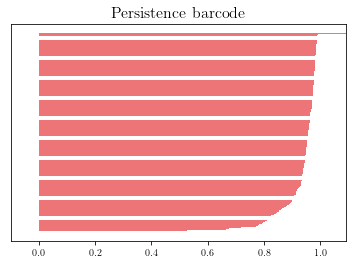

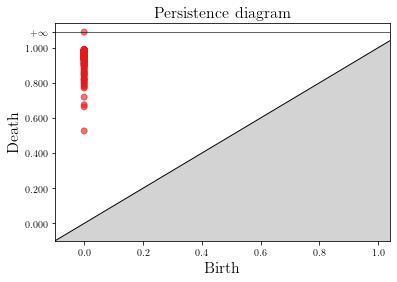

In [22]:
# build VR complex
VR_complex = gudhi.RipsComplex\
    (distance_matrix=gudhi.reader_utils.read_lower_triangular_matrix_from_csv_file
    ('DistanceMatrix.csv', separator = ','), max_edge_length=1)
#then use the complex to build a simplex tree (only dimension 1 is needed since we are focused on clustering)
simplex_tree = VR_complex.create_simplex_tree(max_dimension=1)

# Compute the persistence, plot and save the barcode and the persistence diagram, then display
persistent_hom = simplex_tree.persistence()
gudhi.persistence_graphical_tools.plot_persistence_barcode(persistent_hom)
plt.pyplot.savefig('Barcode')
gudhi.persistence_graphical_tools.plot_persistence_diagram(persistent_hom)
plt.pyplot.savefig('PersistenceDiagram')
plt.pyplot.show()

The barcode and diagram are in line with our intuition: all but one cluster vanish after $\epsilon = 1$, since under the metric we used two tags cannot be farther than a distance of $1$ apart. Naturally, though, we do not care about distinct clusters below a certain value. The persistence diagram suggests that the vast majority of deaths occur between $0.8$ and $1$. One can take a peek at the "DistanceMatrix.csv" file and observe that, indeed, most pairwise distances occur in this range.

In [26]:
pd.read_csv("DistanceMatrix.csv").head()

,0.0,0.9970435193945127,0.9960207803691832,0.9928571428571429,0.9589846192322121,0.9953728186144897,0.8418590143480973,0.7704020530367836,0.9992736780941314,0.9286177806619078,...,1.0.39,1.0.40,0.9982209922909666,0.9998049541642285,0.9996041171813144,1.0.41,1.0.42,1.0.43,0.9994099134539732,0.9998020977637048.1
0,0.997044,0.000000,0.997916,0.998820,0.998267,0.999678,0.992826,0.997580,0.996533,0.999232,...,0.999726,0.998902,1.000000,0.999197,1.000000,0.999179,1.000000,0.999453,0.999730,0.999727
1,0.996021,0.997916,0.000000,0.996467,0.998006,0.906230,0.994852,0.998278,0.997700,0.998278,...,1.000000,0.999529,0.999533,0.998385,0.999296,1.000000,1.000000,0.999531,1.000000,0.999766
2,0.992857,0.998820,0.996467,0.000000,0.997990,0.995388,0.992960,0.994131,0.993504,0.997737,...,1.000000,0.999044,0.995479,0.999766,1.000000,1.000000,0.998092,0.999286,0.994785,0.999524
3,0.958985,0.998267,0.998006,0.997990,0.000000,0.995520,0.946812,0.951301,0.999251,0.986375,...,1.000000,0.999140,1.000000,0.999441,0.999715,0.999429,1.000000,1.000000,1.000000,0.999430
4,0.995373,0.999678,0.906230,0.995388,0.995520,0.000000,0.997082,0.998778,0.997612,0.998150,...,1.000000,0.999638,1.000000,1.000000,0.999281,0.999640,1.000000,1.000000,1.000000,1.000000


So to determine which clusters are "most meaningful," we will only look at those persisting beyond a reasonably high value, say $0.98$:

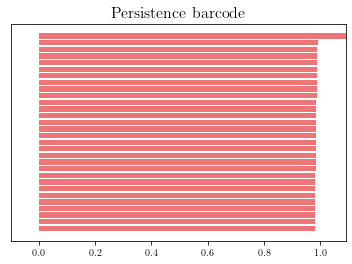

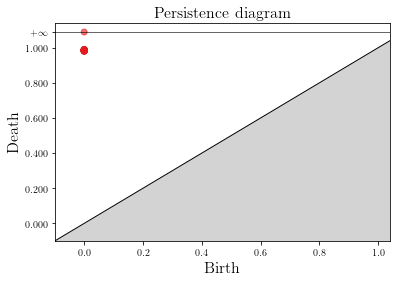

In [38]:
persistent_hom = simplex_tree.persistence(min_persistence=0.98)
gudhi.persistence_graphical_tools.plot_persistence_barcode(persistent_hom)
gudhi.persistence_graphical_tools.plot_persistence_diagram(persistent_hom)
plt.pyplot.show()

This narrows it down to $30$ distinct clusters (really $29$, as the one persisting to infinity is a "trivial cluster" consisting of all tags). We can narrow it down even further by restricting to, say, $0.988$. We'll also include just the barcode here, as the distances are getting much too small for the persistence diagram to be of use.

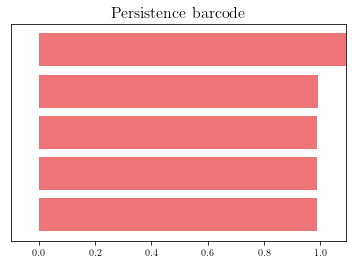

In [47]:
persistent_hom = simplex_tree.persistence(min_persistence=0.988)
gudhi.persistence_graphical_tools.plot_persistence_barcode(persistent_hom)
plt.pyplot.show()

We conclude that, since the minimum persistence of the clusters above is relatively close to $1$, any given tag on a Stack Overflow post is likely to belong to one of these clusters. And to reiterate, tags in the same cluster are used quite often together. A possible application of these findings is as follows: if a user has engaged with posts having a particular tag $T$, other posts relevant to the user may be recommended to them by showing them posts whose tags belong to the same clusters as $T$.